In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn.decomposition, sklearn.cluster
from nheatmap import nhm, scripts
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc

# create a color dictionary for tissues
def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

In [61]:
cell_type = 'macrophage'
adata = sc.read_h5ad('../../data/TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.h5ad', backed='r+')                                                                                       
adata = adata[adata.obs.cell_ontology_class == cell_type]

adata = adata.to_memory()
adata = adata[~adata.obs.tissue.isin(['Salivary_Gland', 'Heart', 'Eye', 'Fat'])]
gene_set = pd.read_csv("../immune_signatures/macrophagetissue_distinguishing_genes.csv", index_col=0)
subset = True

if subset:
    adata = adata[:,adata.var.index.isin(gene_set.iloc[:,0])]

def _pp(adata, log, normalize, remove_dissociation):
    if normalize:
        sc.pp.normalize_total(adata)
    if log:
        sc.pp.log1p(adata, chunk_size=50000)
        adata.raw = adata
    if remove_dissociation:
    #mouse2human = pd.read_csv('../metadata/mouse2human.csv')
        dissociation_genes = pd.read_csv('../metadata/Mouse2Human_dissociation_genes.csv')
        adata.var['not_dissociation_gene'] = ~adata.var.index.isin(dissociation_genes['Human gene name'])
        adata = adata[:, adata.var.not_dissociation_gene == True]
    highly_variable = False
    sc.pp.highly_variable_genes(adata, n_top_genes=500)

    if highly_variable:
        adata = adata[:,adata.var.highly_variable == True]

    return adata

adata = _pp(adata, True, True, False)

/home/michaelswift/miniconda3/envs/scirpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


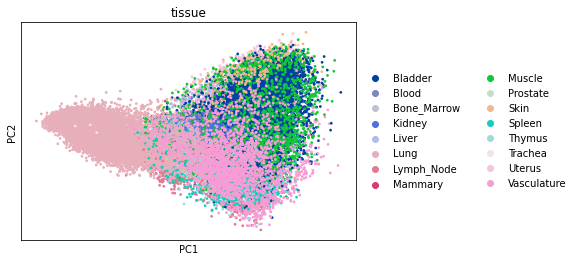

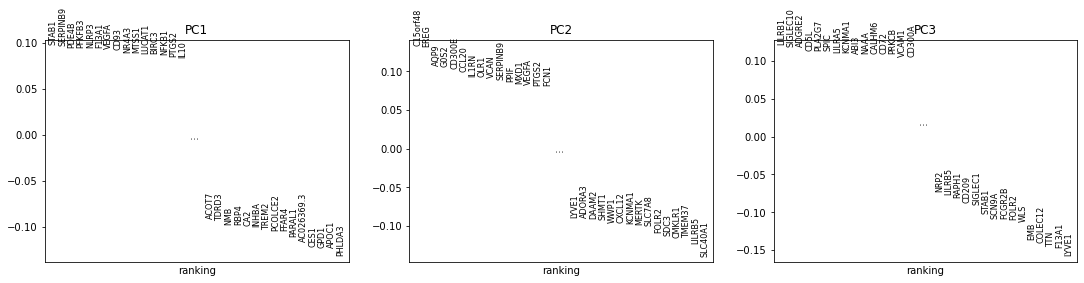

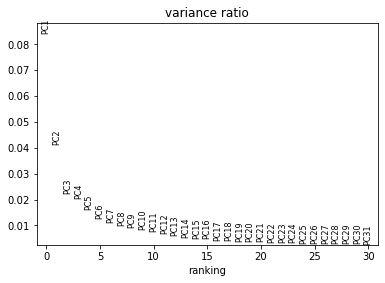

In [62]:
sc.pp.scale(adata, max_value=3)

sc.pp.pca(adata)

sc.pl.pca_overview(adata, color = ['tissue'], projection = '2d', size = 30)

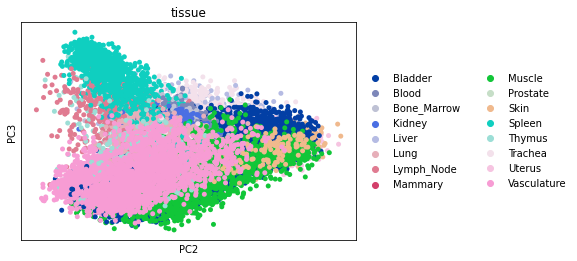

In [63]:
sc.pl.pca(adata, components=[2,3], color='tissue', size = 100)

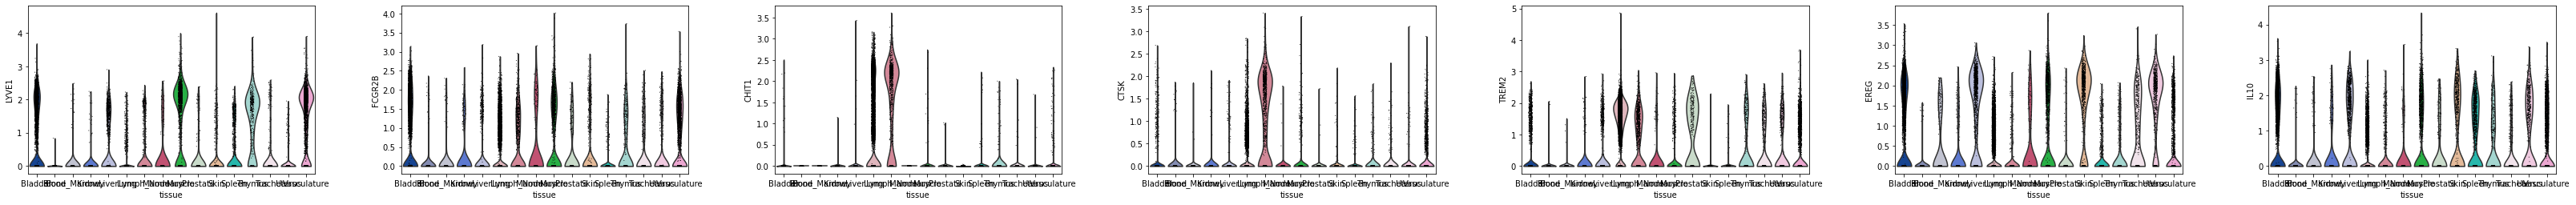

In [64]:
sc.pl.violin(adata, keys=['LYVE1','FCGR2B', 'CHIT1', 'CTSK', 'TREM2', 
                         'EREG', 'IL10'], groupby='tissue')

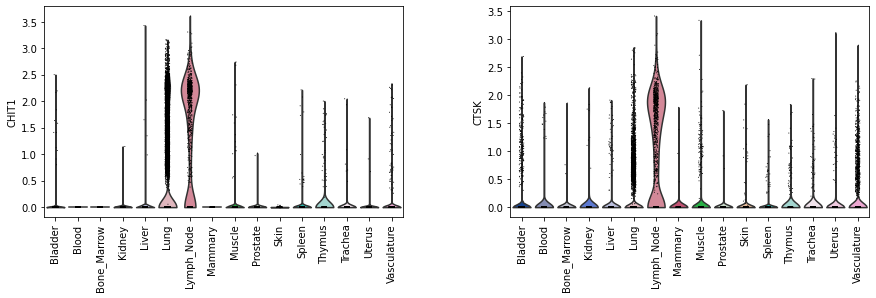

In [65]:
sc.pl.violin(adata, keys=['CHIT1', 'CTSK'], groupby='tissue', rotation=90)

Trying to set attribute `.uns` of view, copying.


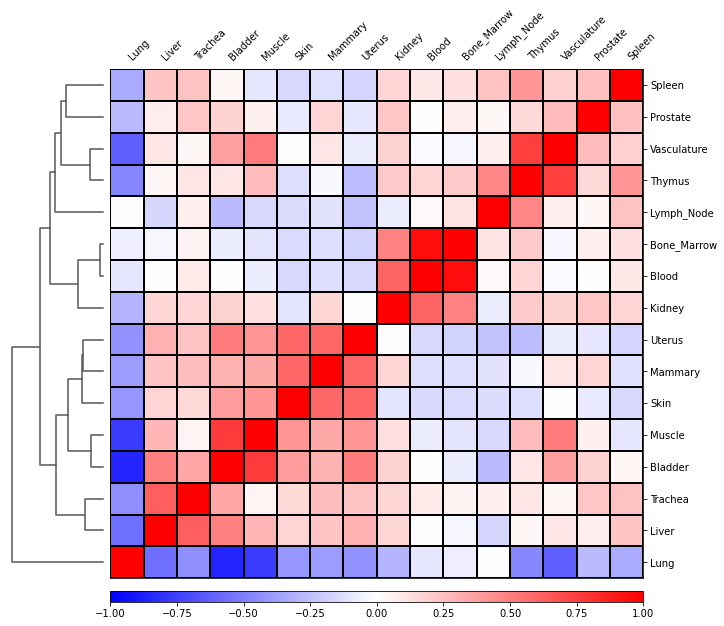

In [66]:
sc.pl.correlation_matrix(adata[:,adata.var.highly_variable == True], groupby='tissue')

Trying to set attribute `.uns` of view, copying.


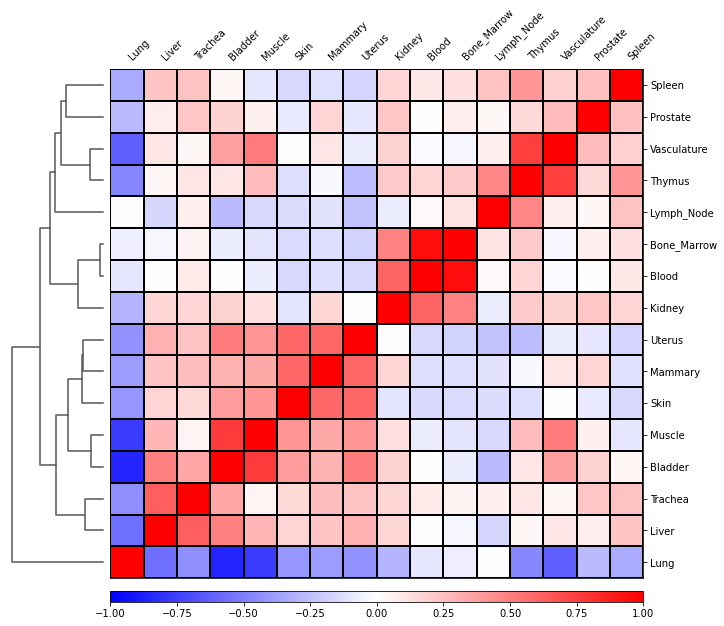

In [67]:
sc.pl.correlation_matrix(adata[:,adata.var.highly_variable == True], groupby='tissue', save='highly_variable_tissue_selected_genes_macrophage')

#### 

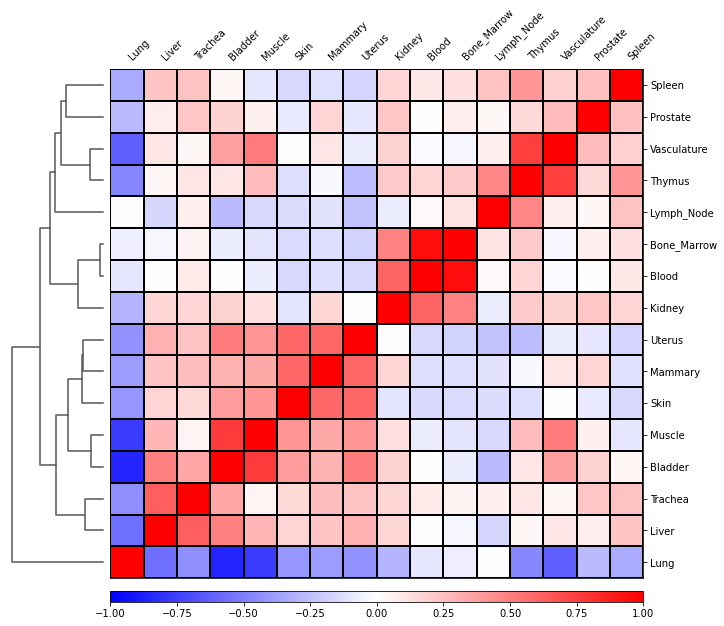

In [68]:
sc.pl.correlation_matrix(adata, groupby='tissue', save='tissue_selected_genes_macrophage')

## nheatmap

In [69]:
def convert_sparse_to_dataframe(adata):
    """ Input: anndata object with sparse matrix as .X attribute
        Returns: Pandas dataframe with rows as cells and columns as genes
        My take: Converting the data to a df inefficient but convenient and possibly more readable"""
    # Get the gene expression values for each cell x gene
    columns = adata.var.index.to_list()
    index = adata.obs.index.to_list()
    try:
        dense_array = adata.X.toarray()
    except:
        dense_array = adata.X
    df = pd.DataFrame(data=dense_array, index=index, columns=columns)
    return df

In [70]:
def make_nheatmap(adata_sub, cluster):

    dfr = sc.get.obs_df(
                    adata_sub,
                    keys=['tissue'])
    pc1 = adata_sub.obsm['X_pca'][:,0]
    pc2 = adata_sub.obsm['X_pca'][:,1]
    pc3 = adata_sub.obsm['X_pca'][:,2]

    dfr['PC1'], dfr["PC2"], dfr["PC3"] = pc1, pc2, pc3

    gene_PC1_score = adata_sub.varm['PCs'][:,0]
    gene_PC2_score = adata_sub.varm['PCs'][:,1]
    gene_PC3_score = adata_sub.varm['PCs'][:,2]

    df = convert_sparse_to_dataframe(adata_sub)

    dfc = sc.get.var_df(
                adata_sub)

    dfc["PC1_score"], dfc["PC2_score"], dfc["PC3_score"] = adata_sub.varm['PCs'][:,0], adata_sub.varm['PCs'][:,1], adata_sub.varm['PCs'][:,2]
    
    # color maps 
    

    cmaps={'PC1':'RdYlGn', 'tissue':tissue_colors(),
        'PC2':'gist_heat', 'PC score 2':'rainbow'}

    g = nhm(data=df, dfr=dfr, dfc=dfc, figsize=(20, 20), showxticks=False, cmaps=cmaps)
    if cluster == True:
        g.hcluster()

    return g

In [71]:
def subset_adata(adata, hvg, fraction):
    adata_sub = adata.copy()
    sc.pp.subsample(adata_sub, fraction=fraction)
    adata_sub = adata_sub[:,adata_sub.var.highly_variable == hvg]
    return adata_sub

In [72]:
adata_sub = subset_adata(adata, True, 0.2)

In [73]:
g = make_nheatmap(adata_sub, False)

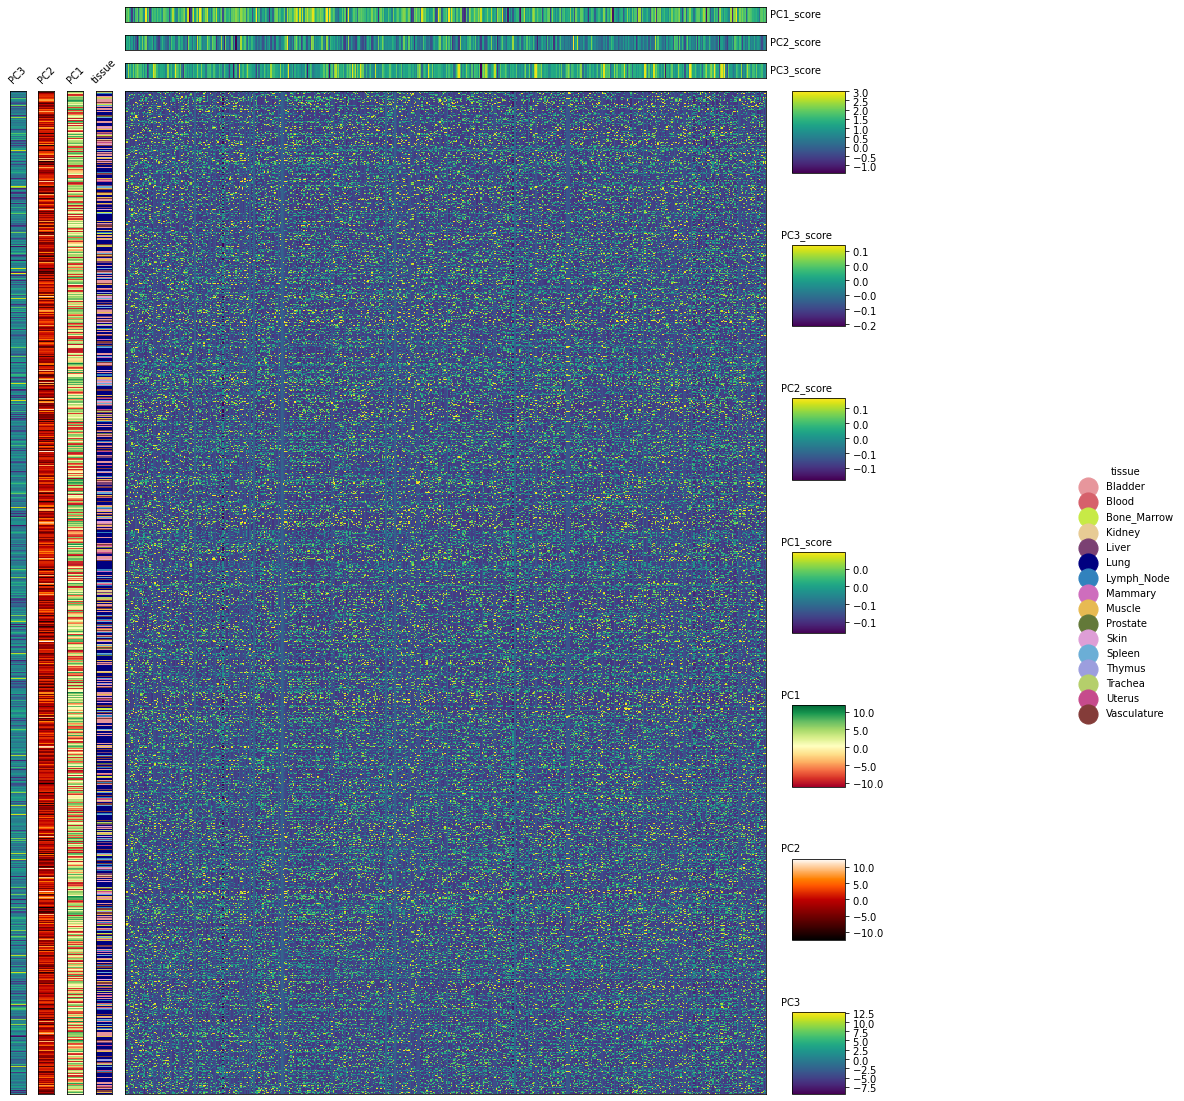

In [74]:
fig, plots = g.run()


In [75]:
g = make_nheatmap(adata_sub, True)

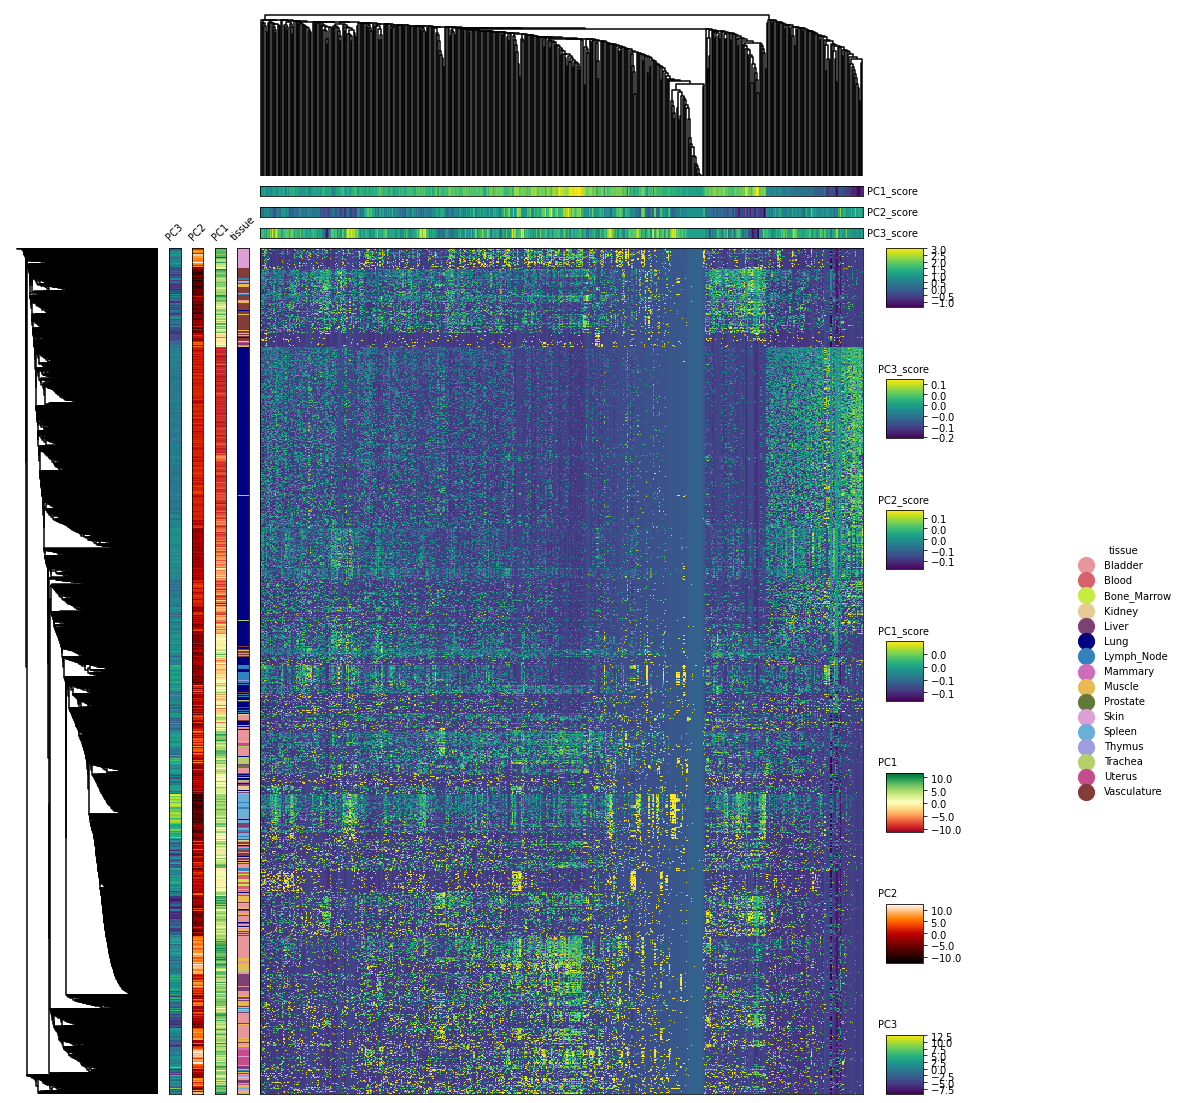

In [76]:
fig, plots = g.run()
